In [1]:
import os
from astropy.table import Table
import pickle

In [2]:
file_dir='./temp/ill_test/' #directory where files for corr_pc will be placed. I recommend using full path rather than relative path as here.
file_name='ill_test_kappa'  #prefix to be appended to the files being saved. Should be different for different datasets.

os.makedirs(file_dir,exist_ok=True)

# from within corr_pc directory, you can run corr_pc as 
# ./corr_pc file_dir/file_name.inp
# For example:
# ./corr_pc ./temp/ill_test/ill_test_Fappa.inp

In [3]:
ill_dir='/hildafs/datasets/IllustrisTNG/TNG100-1/' #path to the illustris data

In [4]:
S_dat_name='TNG100-1_99_galaxy_component_shapes_3I_subfind_mass-cut9' #filenames within illustris from which to read data
D_dat_name='TNG100-1_99_galaxy_component_shapes_3I_subfind_mass-cut9'

In [5]:
#read in shape sample
fname=ill_dir+S_dat_name+'.p'
with open(fname, "rb") as input_file:
    S_dat =pickle.load(input_file)
S_dat=Table(S_dat) #astropy table format, see to add new columns

In [6]:
#define x,y,z columns for cordinates. We will use the names x,y,z, below, instead of gal_pos_x etc. Different versions of the catalog have different naming conventions, please check.
# We will also use units of Mpc instead of Kpc, hence division by 1000
S_dat['x']=float64(S_dat['gal_pos_x']/1000)
S_dat['y']=float64(S_dat['gal_pos_y']/1000)
S_dat['z']=float64(S_dat['gal_pos_z']/1000)

# Tidal field from projected density field

In [7]:
nbins=1000 #this determines the grid resolution. resolution per side = 75/nbins in mpc/h.
be=np.linspace(0,75,nbins+1)
bc=0.5*(be[1:]+be[:-1])

In [8]:
galaxy_counts,ye,xe=np.histogram2d(S_dat['x'],S_dat['y'],bins=(be,be))

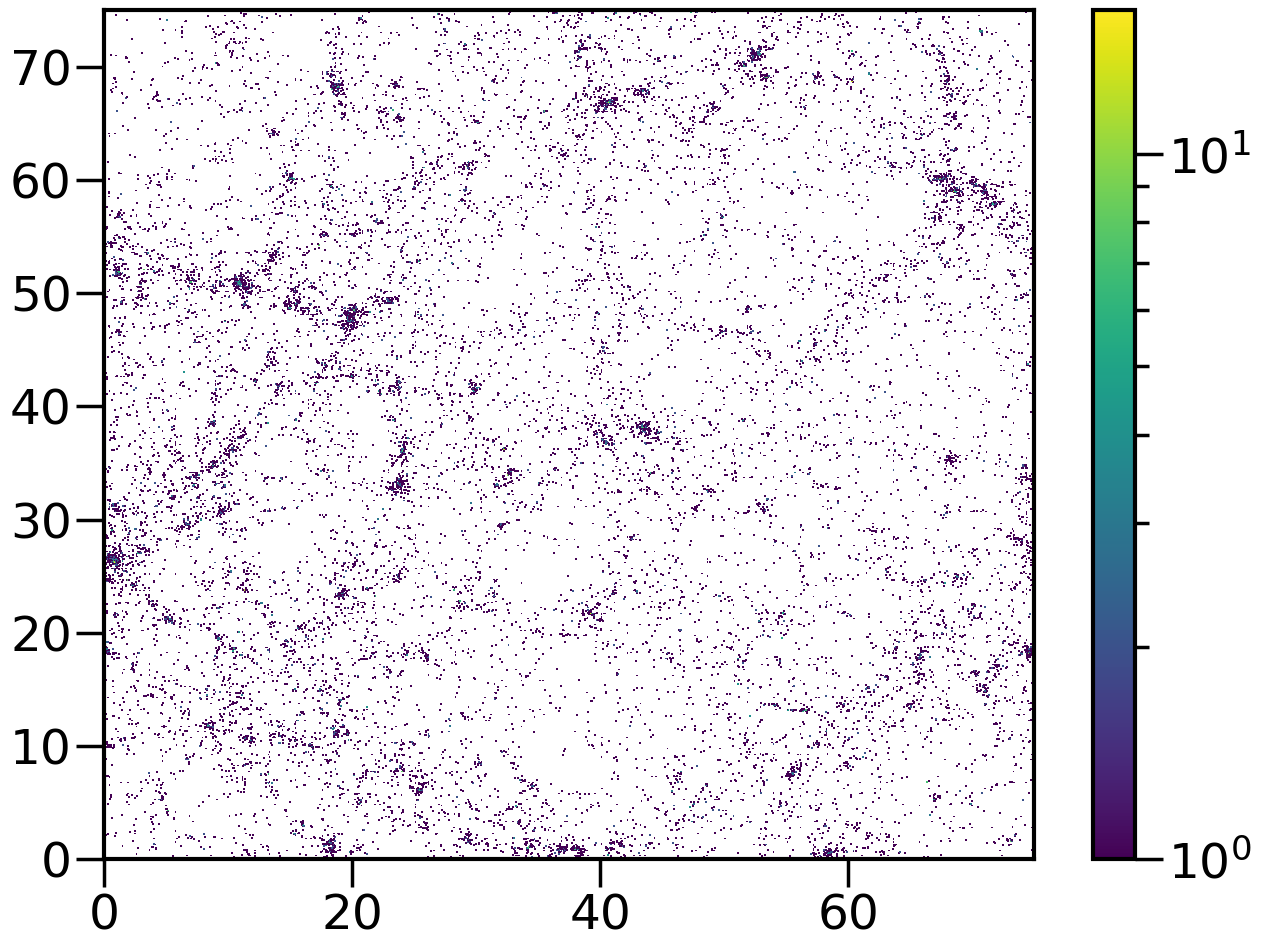

In [9]:
pcolor(bc,bc,galaxy_counts.T,norm=LogNorm())
colorbar()

In [10]:
k=np.fft.fftfreq(nbins, d=be[1]-be[0]) #fourier modes
k2=(k[:,None]**2+k[None,:]**2) #square of fourier modes

In [11]:
delta_R=galaxy_counts/galaxy_counts.mean()-1 #real space density field
delta_F=np.fft.fft2(delta_R)#fourier space density field

In [12]:
#apply gaussian smoothing kernel
smooth_r=1 #smoothing scale, in mpc/h
smooth_F=2*np.pi/smooth_r

smooth_filter=np.exp(-k2/(2*smooth_F**2))

delta_smooth_F=delta_F*smooth_filter
delta_smooth_R=np.fft.ifft2(delta_smooth_F)

In [13]:
potential_smooth_F=delta_smooth_F/k2#fourier space potential

tidal1_F=delta_smooth_F*(k[:,None]**2-k[None,:]**2)/k2 #fourier space tidal field
tidal2_F=delta_smooth_F*(k[:,None]*k[None,:])/k2

tidal1_F[np.where(k2==0)]=0 #correct for divide by 0
tidal2_F[np.where(k2==0)]=0
potential_smooth_F[np.where(k2.T==0)]=0

/tmp/ipykernel_2856824/869934927.py:1: RuntimeWarning: divide by zero encountered in true_divide
  potential_smooth_F=delta_smooth_F/k2#fourier space potential
/tmp/ipykernel_2856824/869934927.py:1: RuntimeWarning: invalid value encountered in true_divide
  potential_smooth_F=delta_smooth_F/k2#fourier space potential
/tmp/ipykernel_2856824/869934927.py:3: RuntimeWarning: invalid value encountered in true_divide
  tidal1_F=delta_smooth_F*(k[:,None]**2-k[None,:]**2)/k2 #fourier space tidal field
/tmp/ipykernel_2856824/869934927.py:4: RuntimeWarning: invalid value encountered in true_divide
  tidal2_F=delta_smooth_F*(k[:,None]*k[None,:])/k2


In [14]:
tidal1_R=np.fft.ifft2(tidal1_F) # real space tidal field
tidal2_R=np.fft.ifft2(tidal2_F)
potential_smooth_R=np.fft.ifft2(potential_smooth_F)


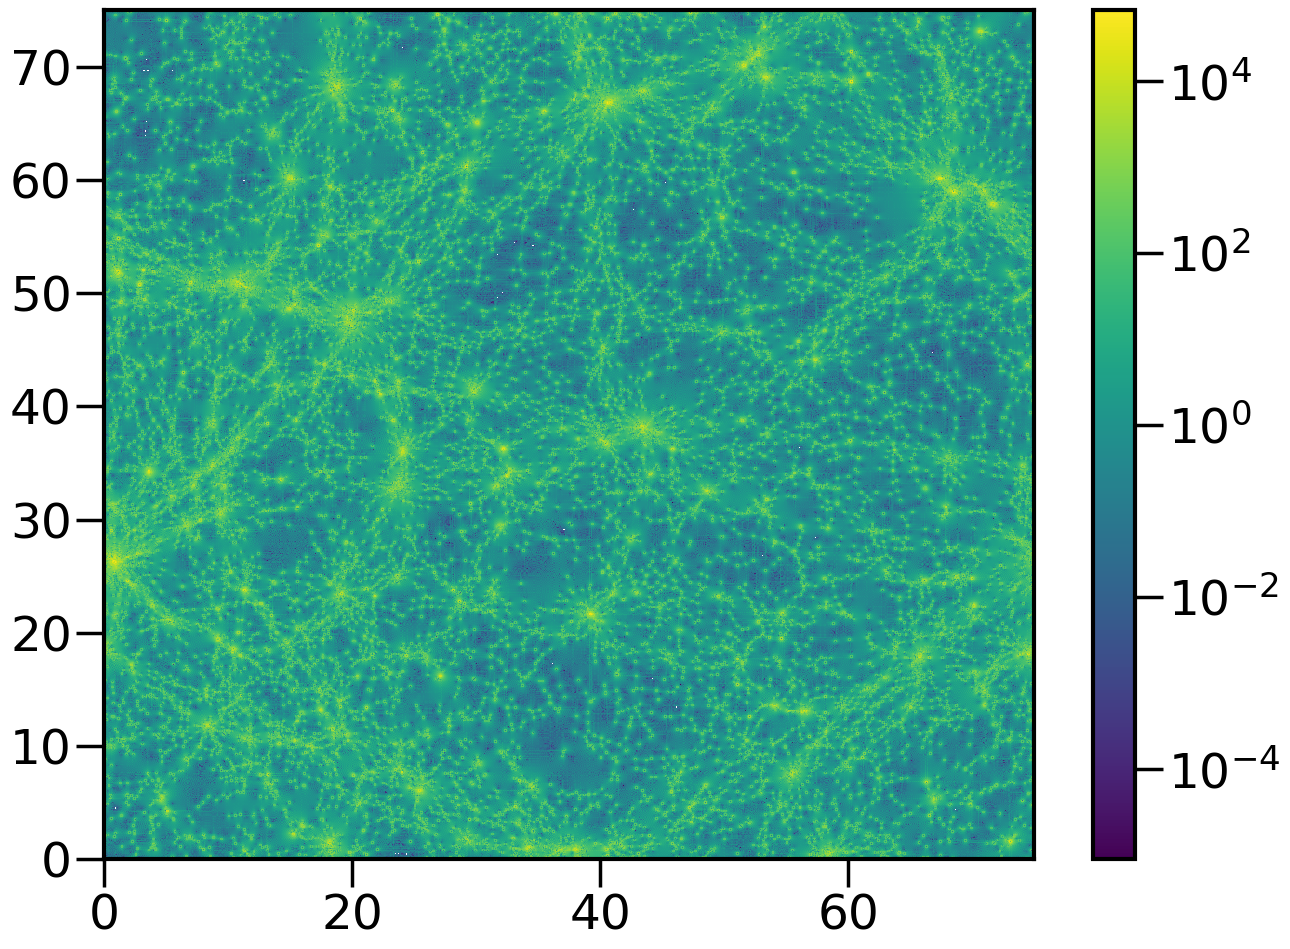

In [15]:
#sanity check
pcolor(bc,bc,np.real(tidal1_R**2+4*tidal2_R**2).T,norm=LogNorm())
colorbar()

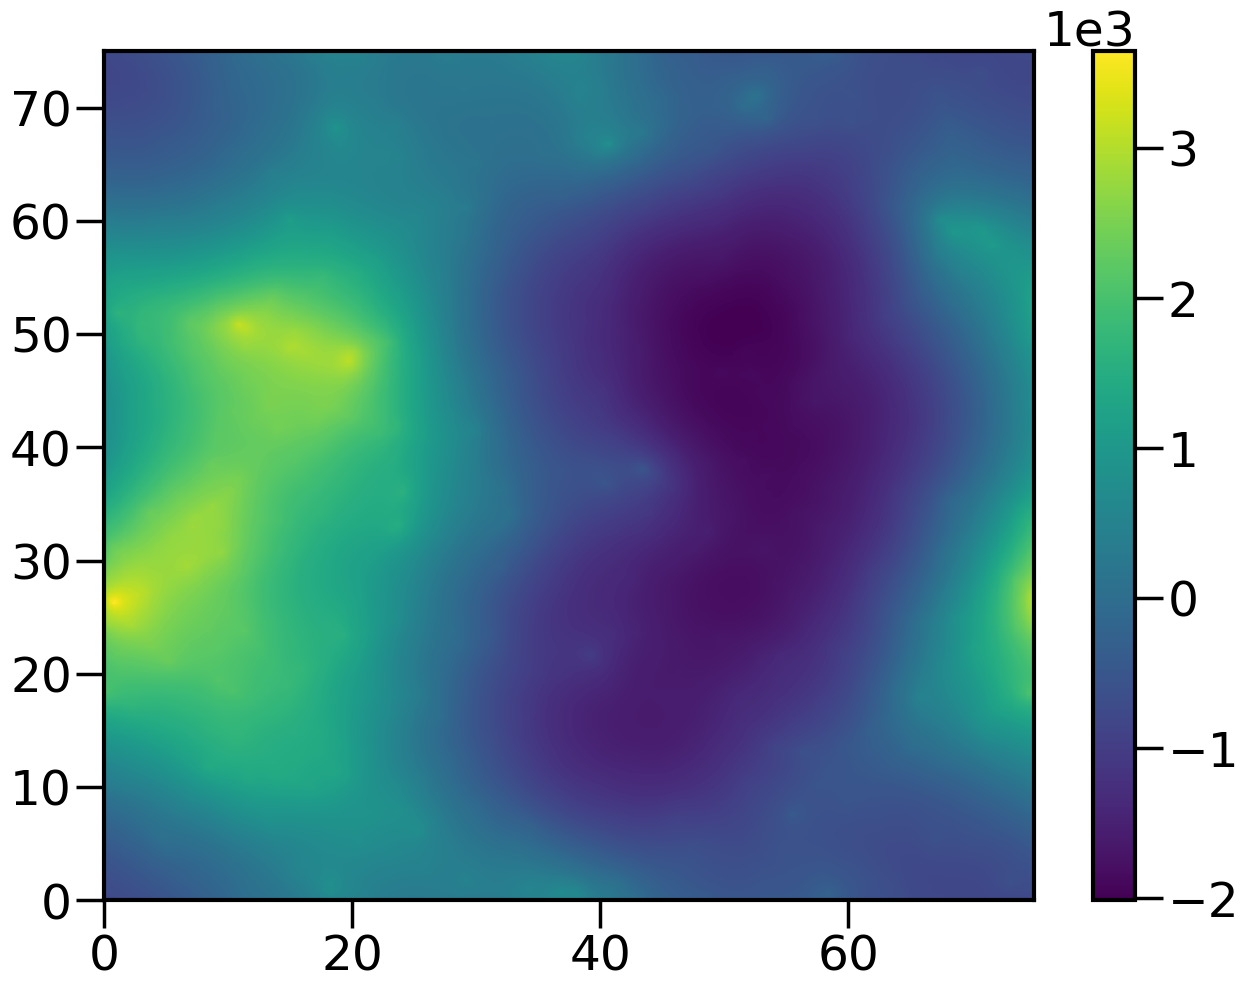

In [16]:
# potential. 
pcolor(bc,bc,np.real(potential_smooth_R).T)
colorbar()

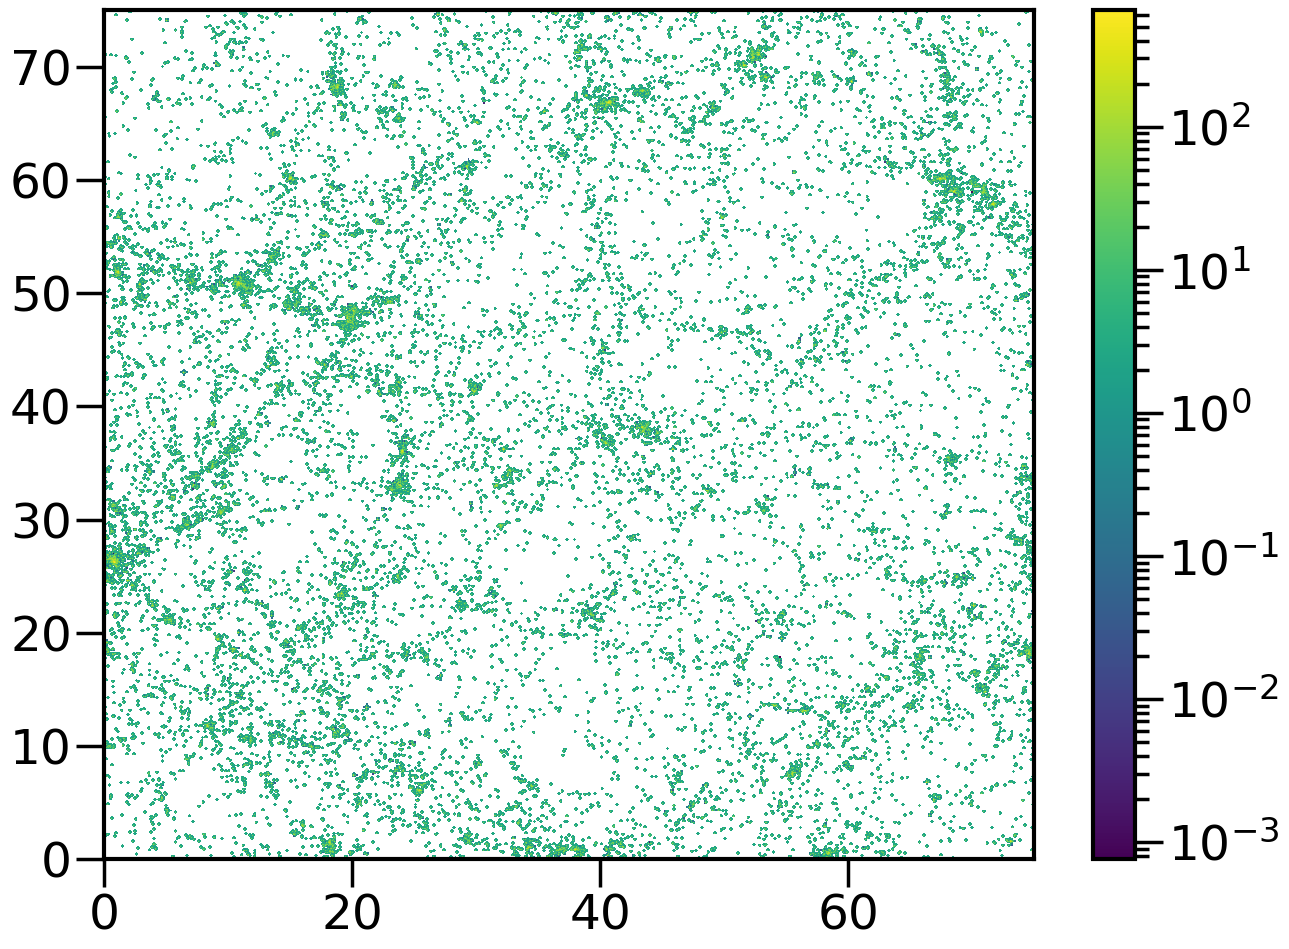

In [17]:
#smoothened density field
pcolor(bc,bc,np.real(delta_smooth_R).T,norm=LogNorm())
colorbar()

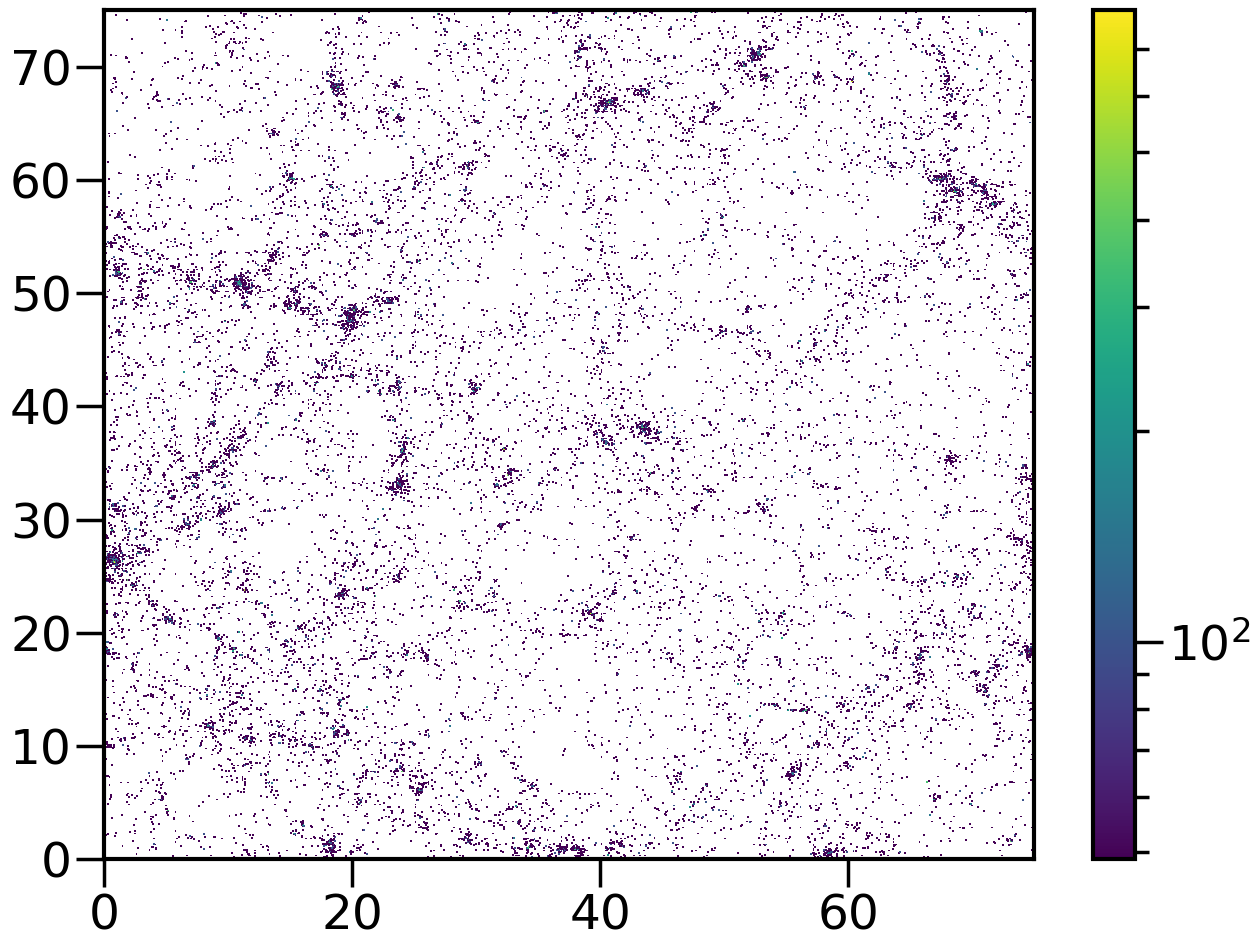

In [18]:
#un-smoothened density field. compare with above
pcolor(bc,bc,np.real(delta_R).T,norm=LogNorm())
colorbar()

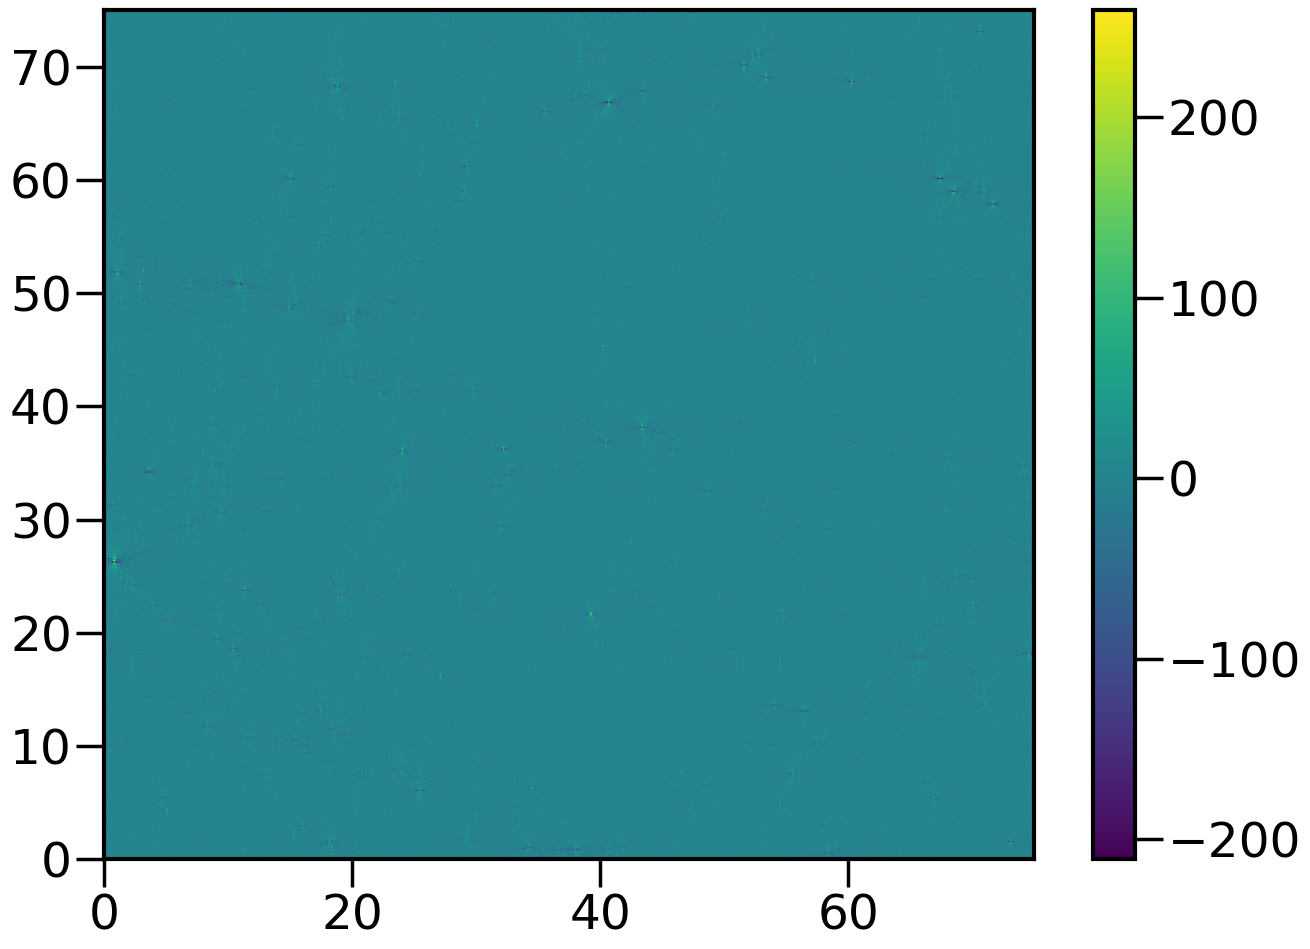

In [19]:
pcolor(bc,bc,np.real(tidal1_R).T)#,norm=LogNorm())
colorbar()

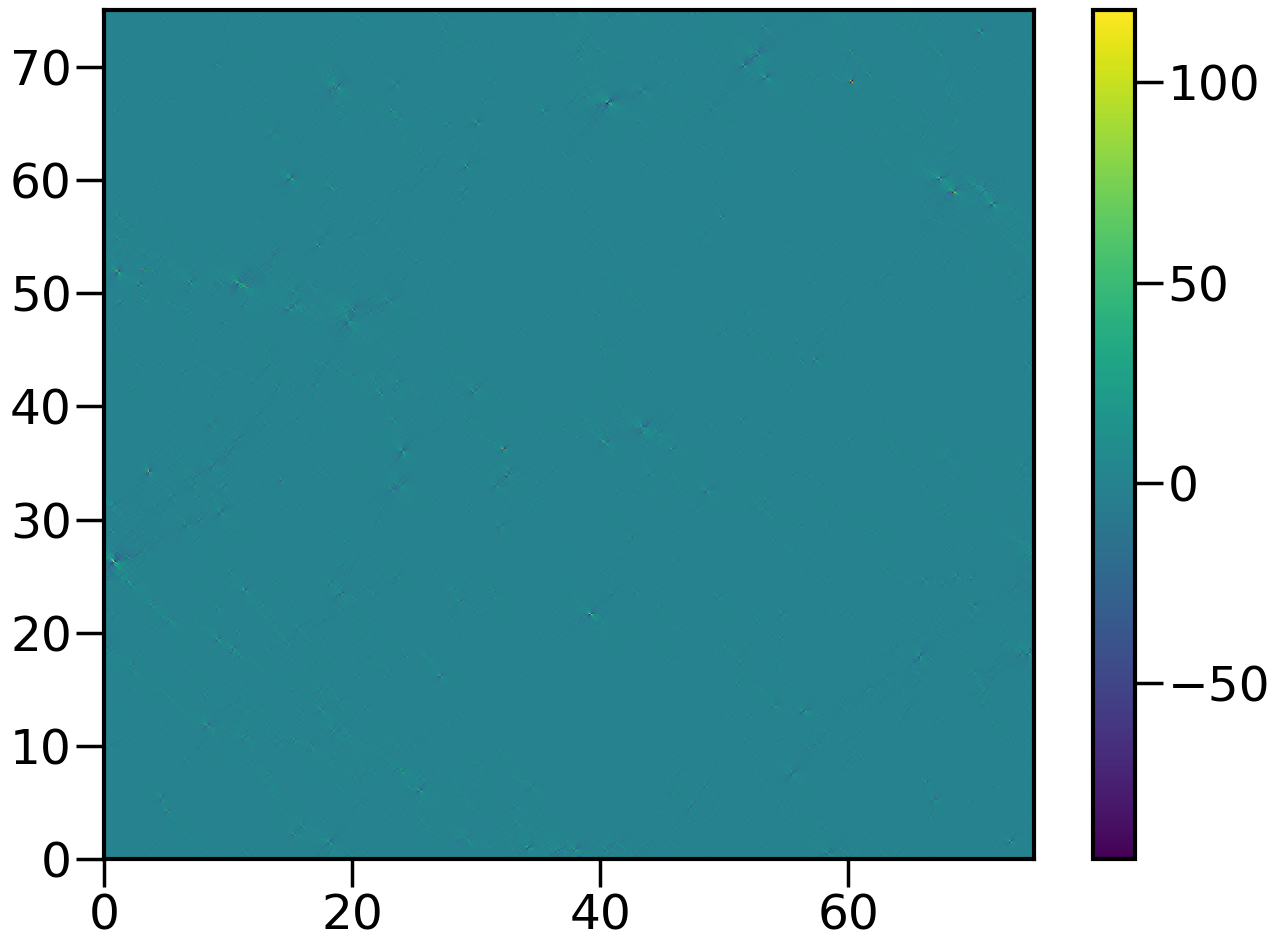

In [20]:
pcolor(bc,bc,np.real(tidal2_R).T)#,norm=LogNorm())
colorbar()

In [21]:
#find indices of grid cells to which galaxies belong
bi={}
for coor in ['x','y']:
    bi[coor]=np.digitize(S_dat[coor],bins=be)-1

In [22]:
#assign 2d density field to galaxies.
galaxies_delta_smooth_R=delta_smooth_R[bi['x'],bi['y']]

#assign 2d tidal field to galaxies.
galaxies_tidal1_R=tidal1_R[bi['x'],bi['y']]
galaxies_tidal2_R=tidal2_R[bi['x'],bi['y']]

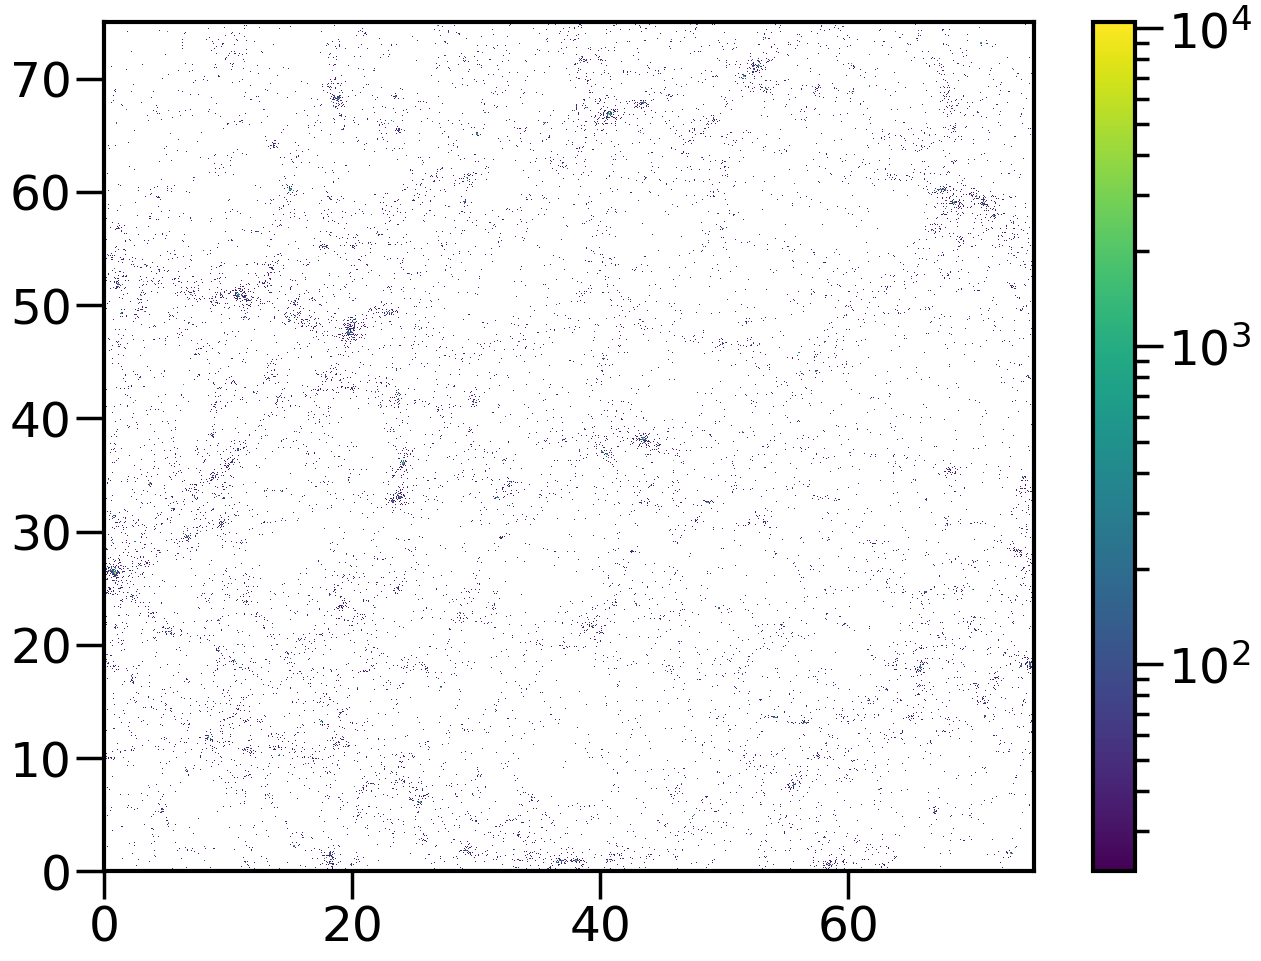

In [23]:
_=hist2d(S_dat['x'],S_dat['y'],bins=(be,be),weights=np.real(galaxies_delta_smooth_R),norm=LogNorm())
colorbar()

#  Tidal field from 3d density field

In [57]:
nbins=750#//2 #this determines the grid resolution. resolution per side = 75/nbins in mpc/h.
be=np.linspace(0,75,nbins+1)
bc=0.5*(be[1:]+be[:-1])

In [58]:
galaxy_counts3d,be3=np.histogramdd(np.array([S_dat['x'],S_dat['y'],S_dat['z']]).T,bins=[be,be,be])

In [59]:
k=np.fft.fftfreq(nbins, d=be[1]-be[0]) #fourier modes
k2=(k[:,None,None]**2+k[None,:,None]**2+k[None,None,:]**2) #square of fourier modes

In [60]:
delta3d_R=galaxy_counts3d/galaxy_counts3d.mean()-1 #real space density field
delta3d_F=np.fft.fftn(delta3d_R)#fourier space density field

In [61]:
#apply gaussian smoothing kernel
smooth_r=.1 #smoothing scale, in mpc/h
smooth_k=2*np.pi/smooth_r

smooth_filter=np.exp(-k2/(2*smooth_k**2))

delta3d_smooth_F=delta3d_F*smooth_filter
delta3d_smooth_R=np.fft.ifft2(delta3d_smooth_F)

In [62]:
potential3d_smooth_F=delta3d_smooth_F/k2

tidal1_3d_F=delta3d_smooth_F*(k[:,None,None]**2-k[None,:,None]**2)/k2
tidal2_3d_F=delta3d_smooth_F*(k[:,None,None]*k[None,:,None])/k2

tidal1_3d_F[np.where(k2==0)]=0
tidal2_3d_F[np.where(k2==0)]=0
potential3d_smooth_F[np.where(k2.T==0)]=0

/tmp/ipykernel_2856824/4096386848.py:1: RuntimeWarning: divide by zero encountered in true_divide
  potential3d_smooth_F=delta3d_smooth_F/k2
/tmp/ipykernel_2856824/4096386848.py:1: RuntimeWarning: invalid value encountered in true_divide
  potential3d_smooth_F=delta3d_smooth_F/k2
/tmp/ipykernel_2856824/4096386848.py:3: RuntimeWarning: invalid value encountered in true_divide
  tidal1_3d_F=delta3d_smooth_F*(k[:,None,None]**2-k[None,:,None]**2)/k2
/tmp/ipykernel_2856824/4096386848.py:4: RuntimeWarning: invalid value encountered in true_divide
  tidal2_3d_F=delta3d_smooth_F*(k[:,None,None]*k[None,:,None])/k2


In [63]:
tidal1_3d_R=np.fft.ifftn(tidal1_3d_F)
tidal2_3d_R=np.fft.ifftn(tidal2_3d_F)
potential3d_smooth_R=np.fft.ifft2(potential3d_smooth_F)


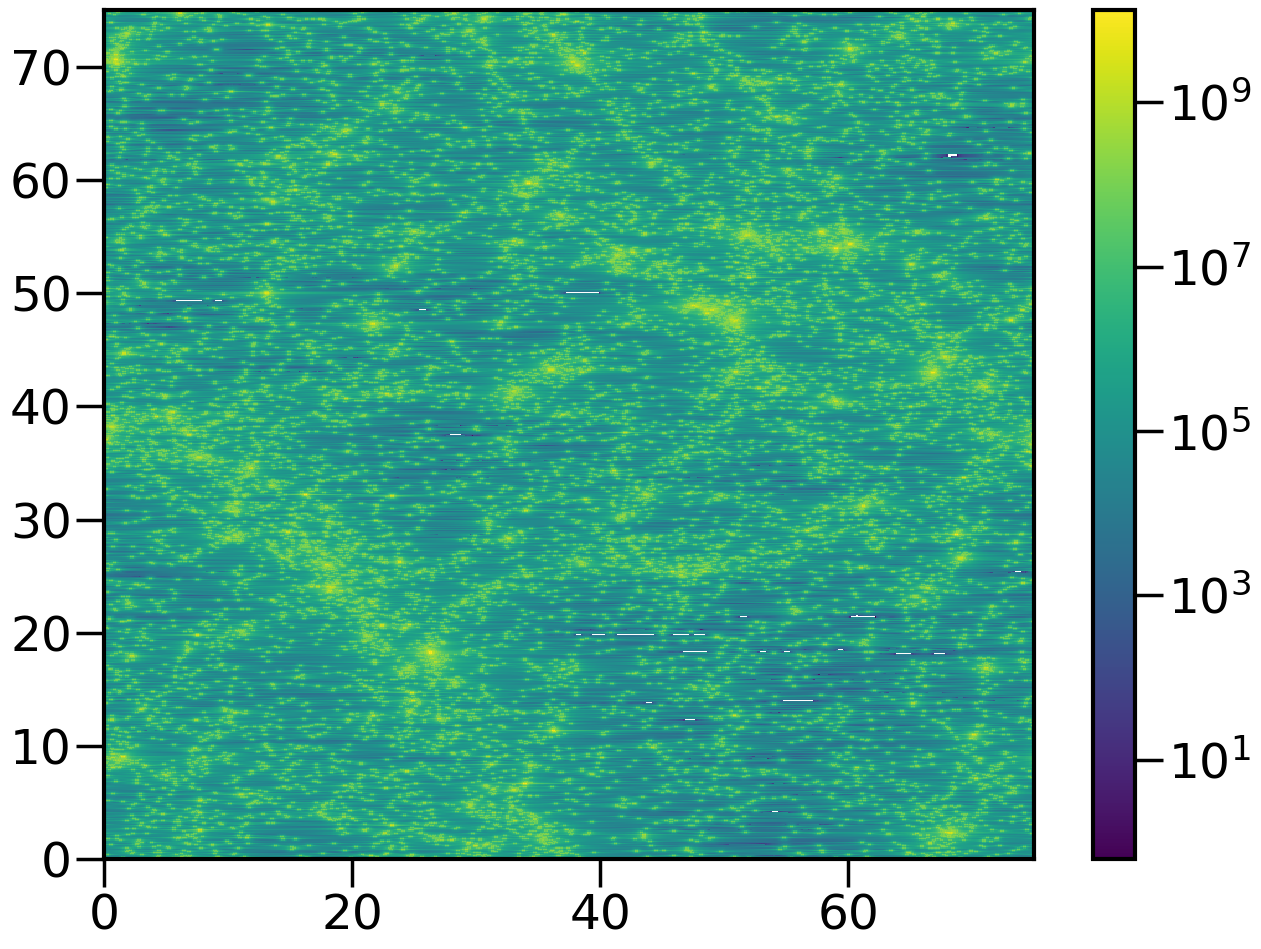

In [64]:
#sanity check
pcolor(bc,bc,np.real(tidal1_3d_R**2+4*tidal2_3d_R**2).sum(axis=0).T,norm=LogNorm())
colorbar()

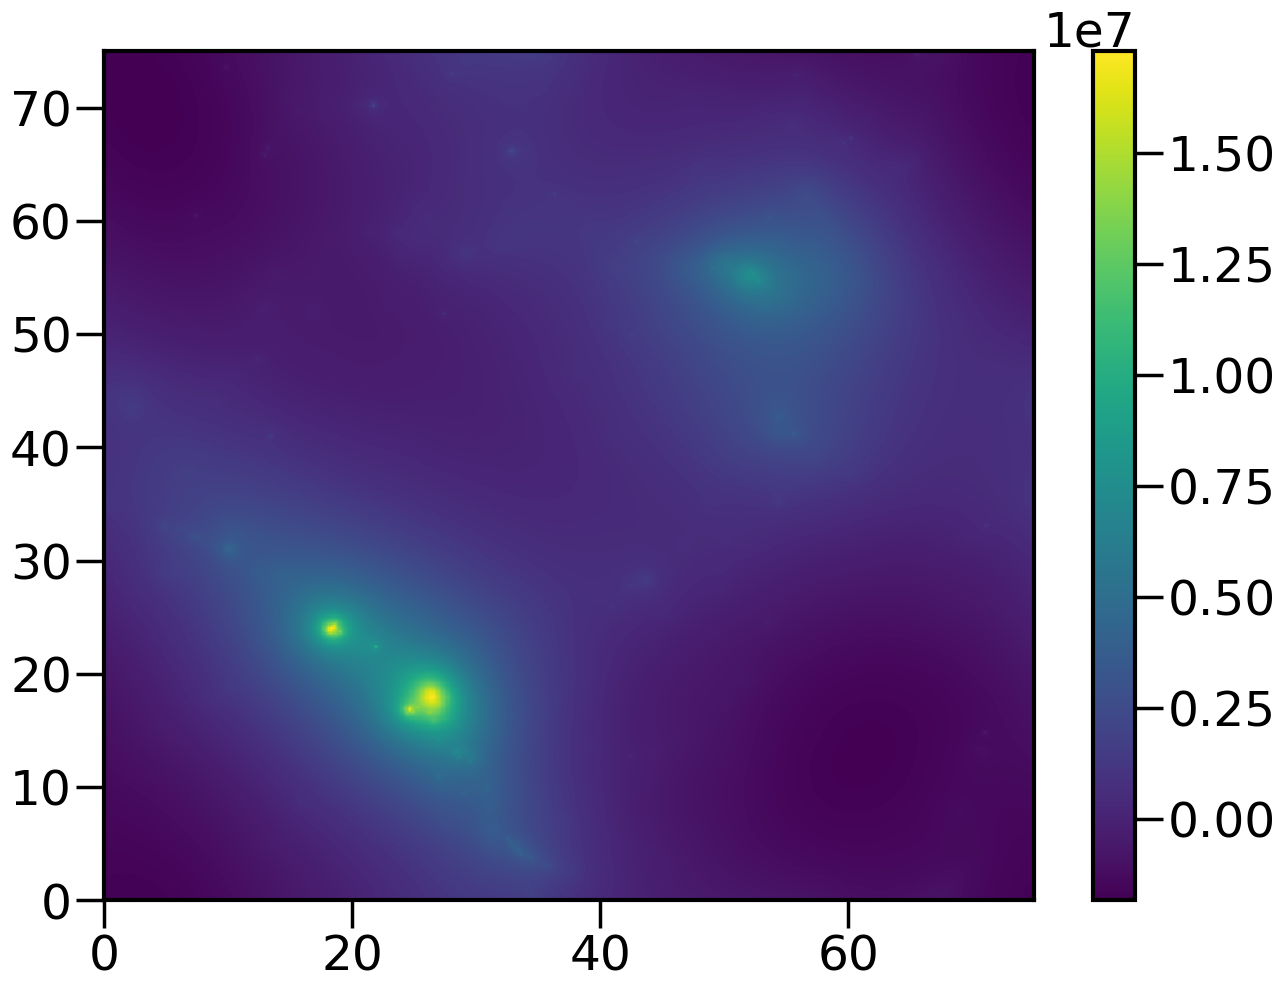

In [65]:
#sanity check
pcolor(bc,bc,np.real(potential3d_smooth_R).sum(axis=0).T)
# pcolor(bc,bc,np.real(potential_smooth_R)[:,:,1].T)
colorbar()

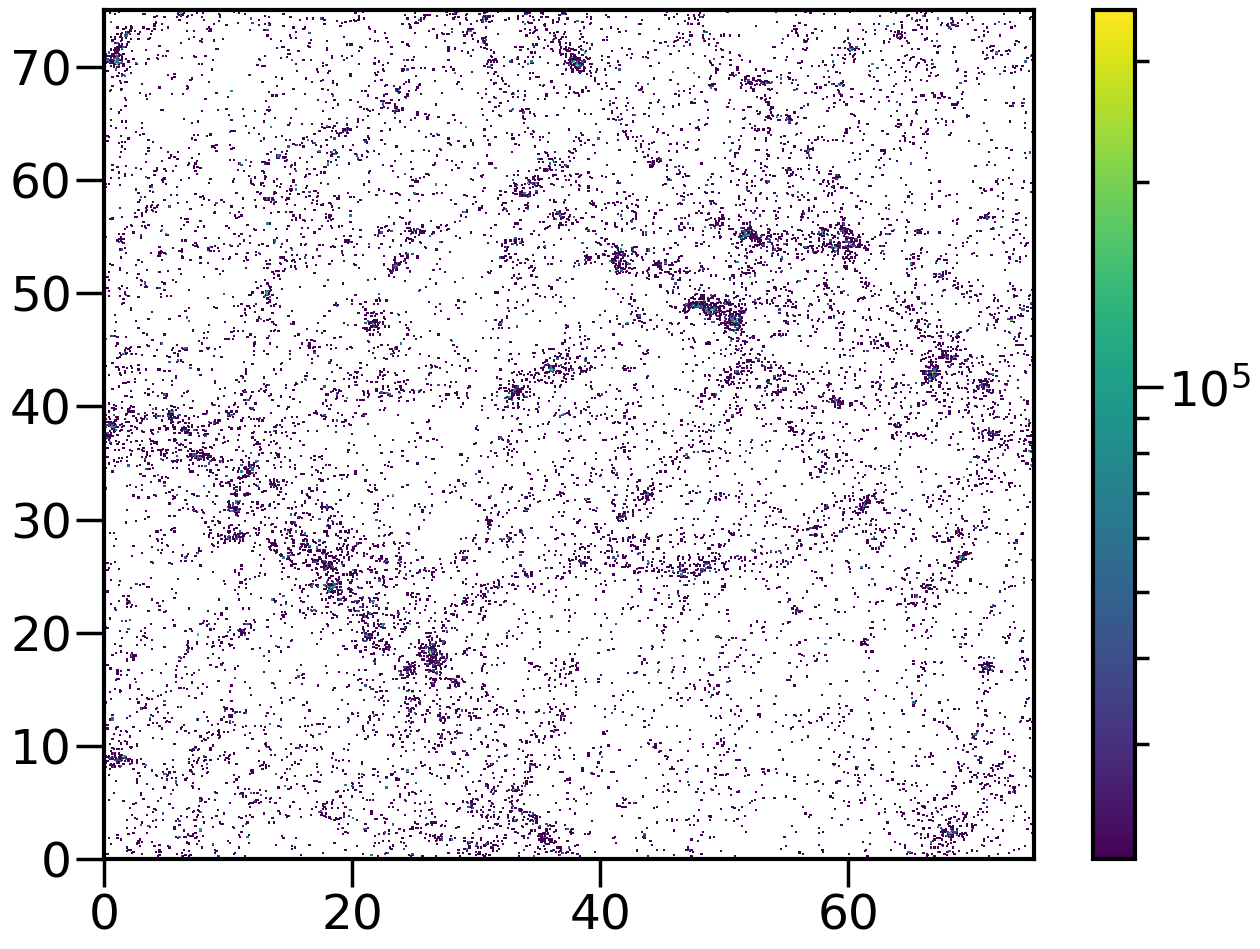

In [73]:
#sanity check
pcolor(bc,bc,np.real(delta3d_R).sum(axis=0).T,norm=LogNorm())
colorbar()

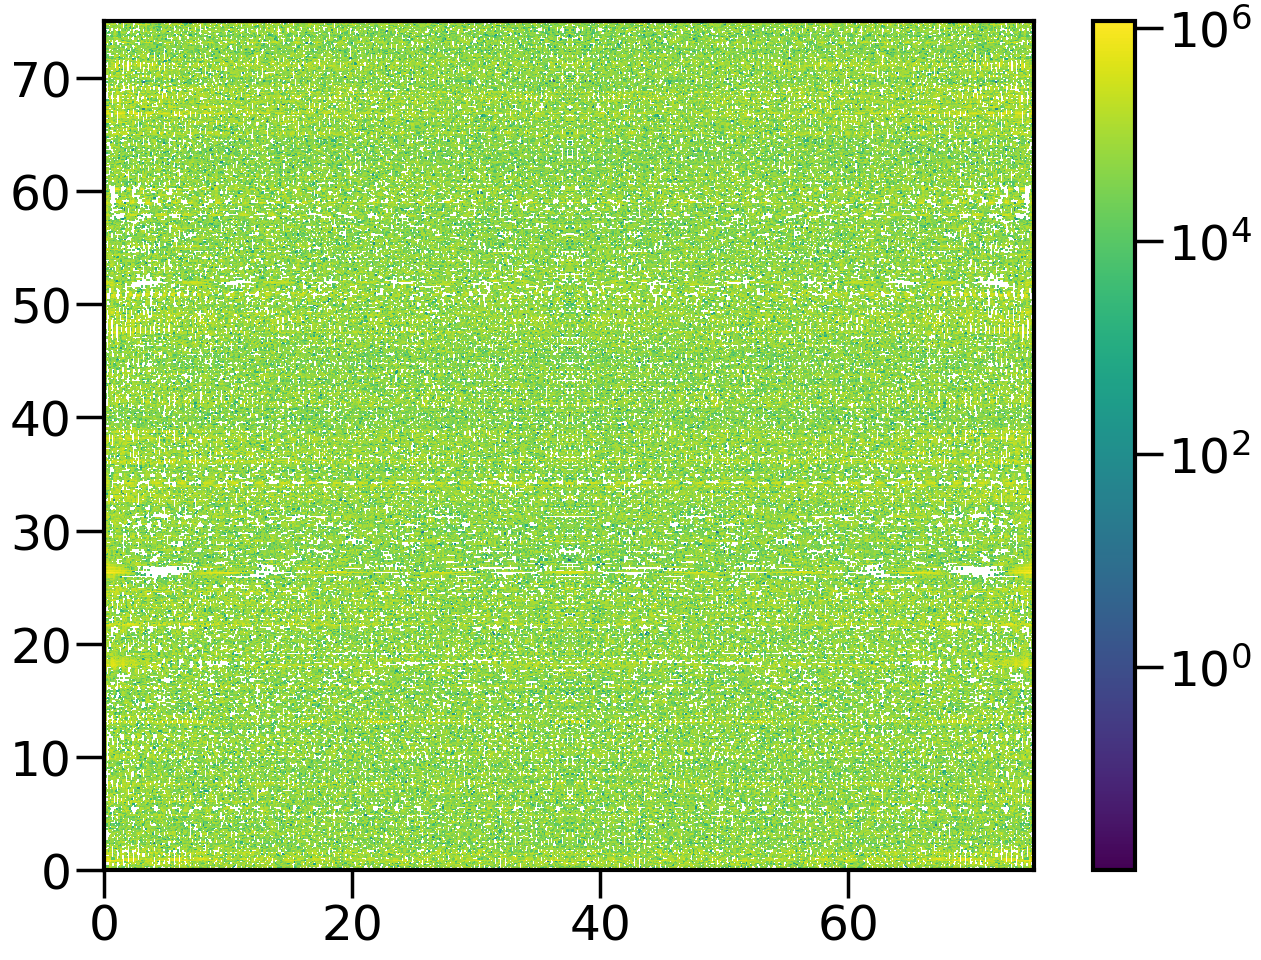

In [67]:
#sanity check
pcolor(bc,bc,np.real(delta3d_smooth_R).sum(axis=-1).T,norm=LogNorm())
colorbar()

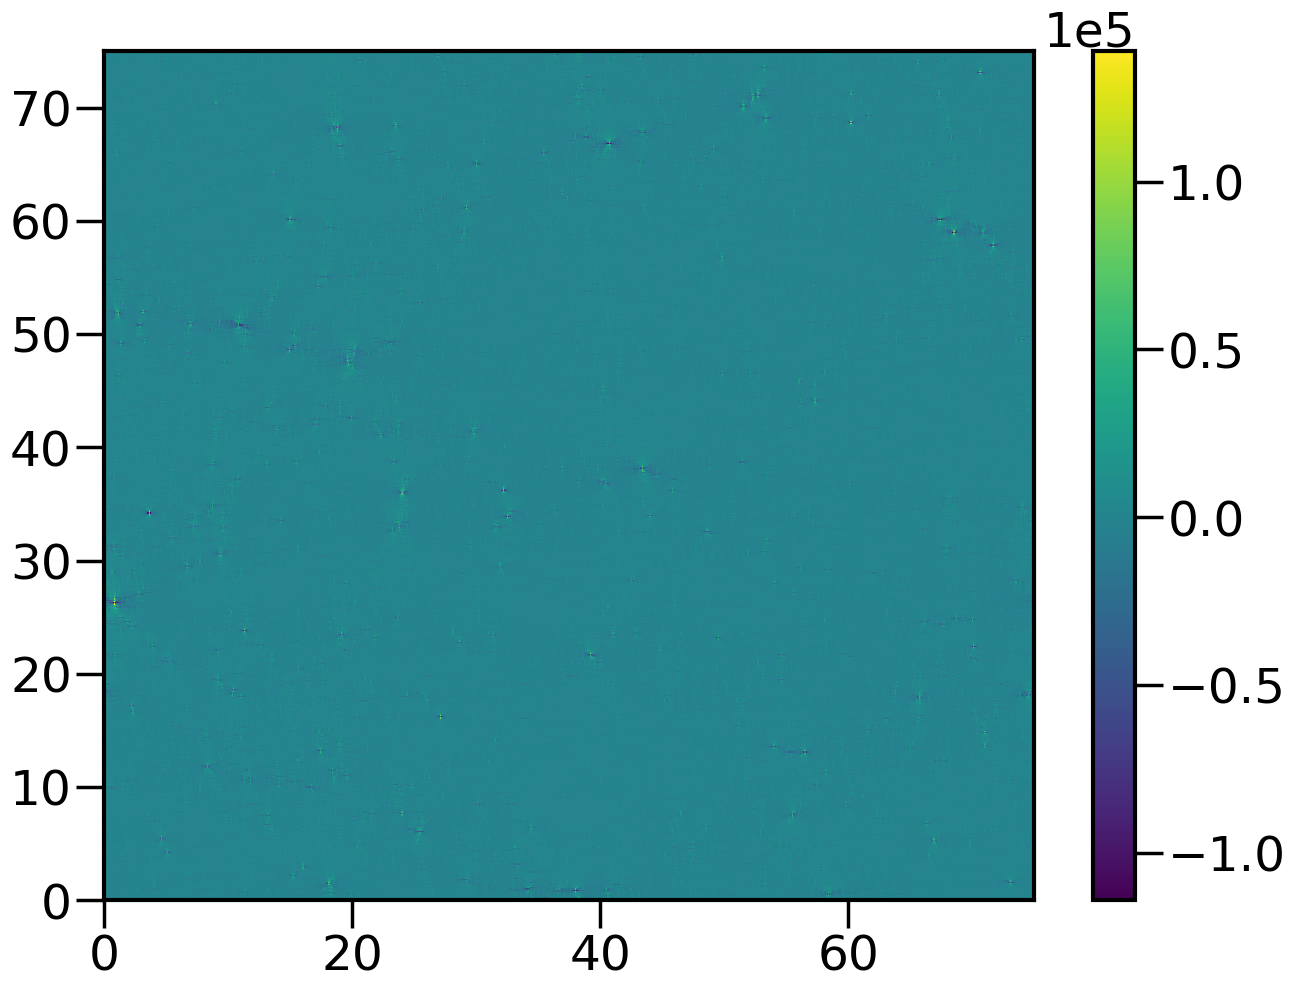

In [68]:
pcolor(bc,bc,np.real(tidal1_3d_R).sum(axis=-1).T)#,norm=LogNorm())
colorbar()

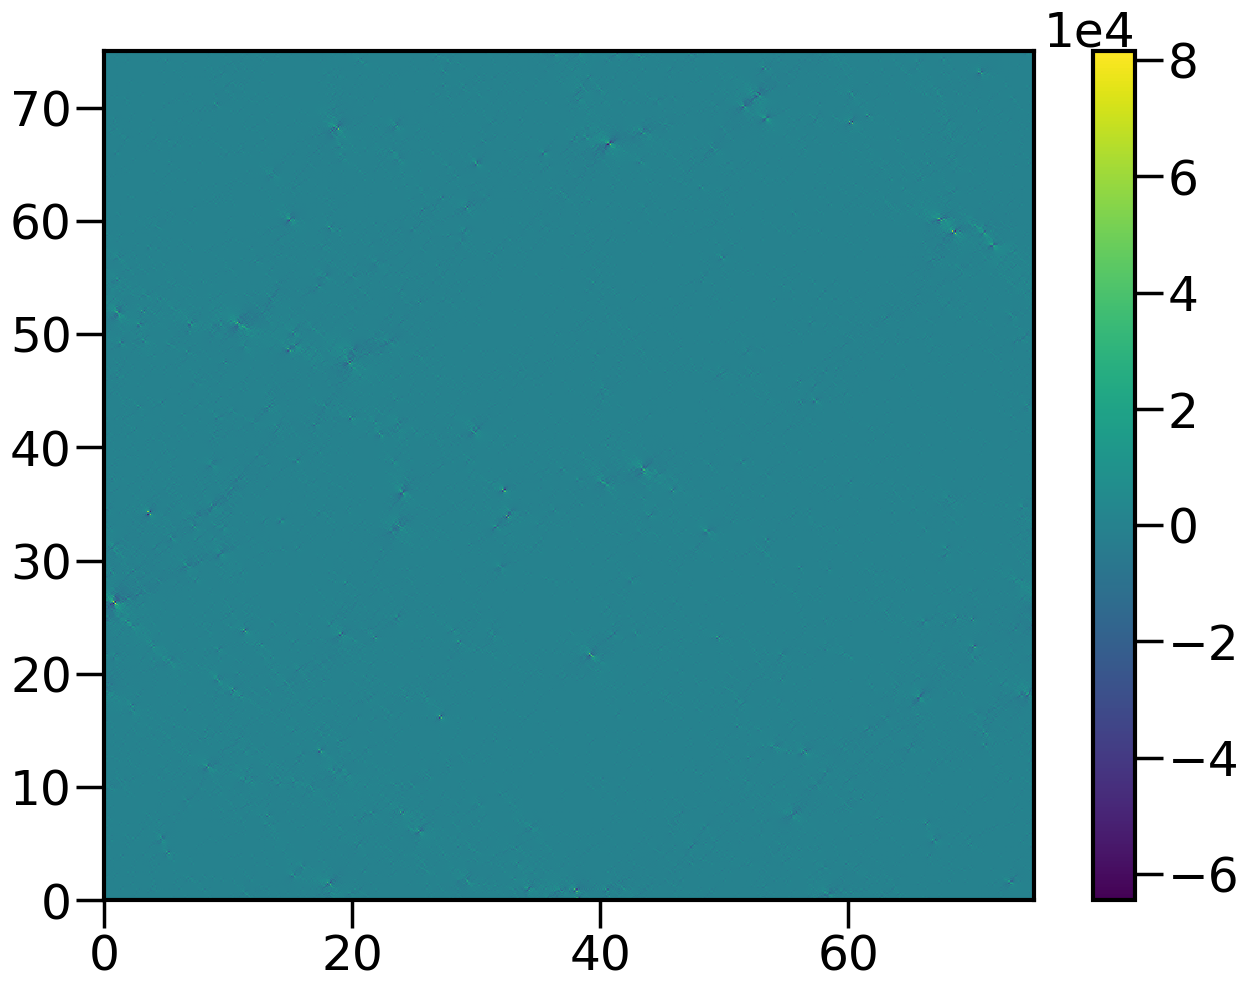

In [69]:
pcolor(bc,bc,np.real(tidal2_3d_R).sum(axis=-1).T)#,norm=LogNorm())
colorbar()

In [70]:
#find indices of grid cells to which galaxies belong
bi={}
for coor in ['x','y','z']:
    bi[coor]=np.digitize(S_dat[coor],bins=be)-1

In [71]:
#assign 3d density to galaxies.
galaxies_delta3d_smooth_R=delta3d_smooth_R[bi['x'],bi['y'],bi['z']]

#assign 3d tidal field to galaxies.
galaxies_tidal1_3d_R=tidal1_3d_R[bi['x'],bi['y'],bi['z']]
galaxies_tidal2_3d_R=tidal2_3d_R[bi['x'],bi['y'],bi['z']]

In [72]:
galaxies_delta3d_smooth_R

array([233138.49682584-141778.58064277j,  84021.56694773   -175.44418492j,
        72250.7904226  -42939.31950856j, ...,
         6481.45838376 +19939.33436156j,  20777.74859449  -2802.98331286j,
        19114.69163637 -19847.73242593j])